# DATA PROCESSING

In this notebook, we will derive insights from **PPMI RNA-seq experimental metadata** and patient **medication data** from the same study. The workflow covers a set of tasks ranging from basic data cleaning and wrangling to feature engineering. Special emphasis is placed on calculating the number of medication and medication time for patients involved in the study. Furthermore, I classified medication data using between **disease-modifying drugs** and **Non-disease-modifying drugs** using openAI gpt-4. Additionally, I also and identified those specifically indicated for Parkinson's disease.

**Felipe Núñez Villena, PhD** <br>
29-09-2023

## Table of Contents

[1 - Import Libraries](#1---import-libraries) <br>
[2 - Load datasets](#2---Load-datasets) <br>
[3 - Data processing](#3---Data-processing)

# <a name="1---import-libraries"></a>1 - Import libraries

In [1]:
import pandas as pd
import os
from dotenv import dotenv_values
from hugchat import hugchat
from hugchat.login import Login
import matplotlib.pyplot as plt
import seaborn as sns

# Langchain
from langchain import FewShotPromptTemplate

from langchain.chat_models import ChatOpenAI

from langchain.prompts import (
    ChatPromptTemplate,
    PromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate
)

# Schemas
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

from tqdm import tqdm
import pickle 

# <a name="2 - Load datasets"></a>2 - Load datasets

In the context of this project, I will be working with the datasets **Medication Data** and **RNA-seq Metadata**. Primarily I will focus on thorough data preprocessing, which involves tasks like **data cleaning** and **wrangling**. Additionally, I will engage in **feature engineering** to create new variables from this data.

In [2]:
Medication = pd.read_csv('Input/Concomitant_Medication_Log_22Aug2023.csv', encoding='utf-8')
RNAseq_metadata = pd.read_csv('Input/meta_data_11192021.csv',encoding='utf-8')

/var/folders/7b/stv1v9_d4nvg0_31qmdnnlsr0000gn/T/ipykernel_87513/1655982589.py:1: DtypeWarning: Columns (7,8,14,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  Medication = pd.read_csv('download/Concomitant_Medication_Log_22Aug2023.csv', encoding='utf-8')


# <a name="3---Dataset processing"></a>3 - Dataset processing

## 3.1 - RNAseq_metadata

### 3.1.1 - RNAseq_metadata processing

In this section, we've undertaken a series of data preprocessing steps to prepare the RNA-seq metadata for our analysis. The process includes several key actions:

First, we removed any prefix 'PP-' from the 'PATNO' column, ensuring uniformity in patient identifiers. Subsequently, we converted the 'PATNO' column to integers for consistency in data type.

To ensure the quality of our dataset, we excluded samples where patient data was missing, enhancing the reliability of our analysis.

We then selected a subset of columns, referred to as 'cols_of_interest,' which contains essential information such as sample names, patient identifiers, visit details, quality control metrics, disease and genetic status, clinical event data, demographics (such as age, sex, and race), and various RNA-seq metrics.

The resulting 'RNAseq_md_filt' dataset contains only these selected columns, streamlining the data for further exploration and analysis. This preprocessing sets the stage for more focused and insightful investigations into the RNA-seq metadata and its relationship to other aspects of the study.

In [4]:
# Remove samples whose patient data is missing
RNAseq_metadata = RNAseq_metadata[RNAseq_metadata['PATNO'].notnull()].copy()
# Remove PP- substring
RNAseq_metadata['PATNO'] = RNAseq_metadata['PATNO'].str.replace('PP-', '')
# convert the PATNO column to integer
RNAseq_metadata['PATNO'] = RNAseq_metadata['PATNO'].astype(int)


# Feature with biological relevance selection
cols_of_interest = ['HudAlphaSampleName', 'Small RNA-Seq', 'Long RNA-seq', 'PATNO',
       'PATNO Visit', 'QC', 'PoolAssign', 'Phase', 'Disease Status', 'Genetic Status', 'Diagnosis', 
        'Case Control','Clinical Event', 'Month', 'Sex', 'Race', 
       'Age (Bin)', 'Age at Consent', 'Age at diagnosis',
       'RIN Value','Usable Bases (%)', 'globin (%)', 'rRNA (%)', 'Multimapped (%)',
       'Uniquely mapped (%)', 'Total reads']

RNAseq_md_filt = RNAseq_metadata[cols_of_interest].copy()

## 3.1.2 - Identifying and quantifiying features with missing data

In this section, we focus on assessing and quantifying missing data within our RNA-seq metadata. Our approach comprises the following steps:

First, we calculate the number of missing values for each column in the 'RNAseq_md_filt' dataset, providing us with an overview of the extent of missing data in our dataset.

Next, we filter the columns that contain missing values, identifying specific features affected by data gaps.

To offer clarity and prioritization, we sort these columns by the number of missing values they contain, providing insight into the severity of data incompleteness for each feature.

We then visualize this information using a bar plot, with each bar representing a feature and its height indicating the count of missing values. Additionally, we label each bar with the precise count of missing values for quick reference.

To emphasize the overall impact of missing data, we include a text label at the top of the plot, highlighting the total number of features with missing values.

This analysis not only allows us to understand the data's quality but also guides us in making informed decisions on how to handle missing data effectively in subsequent stages of our study.

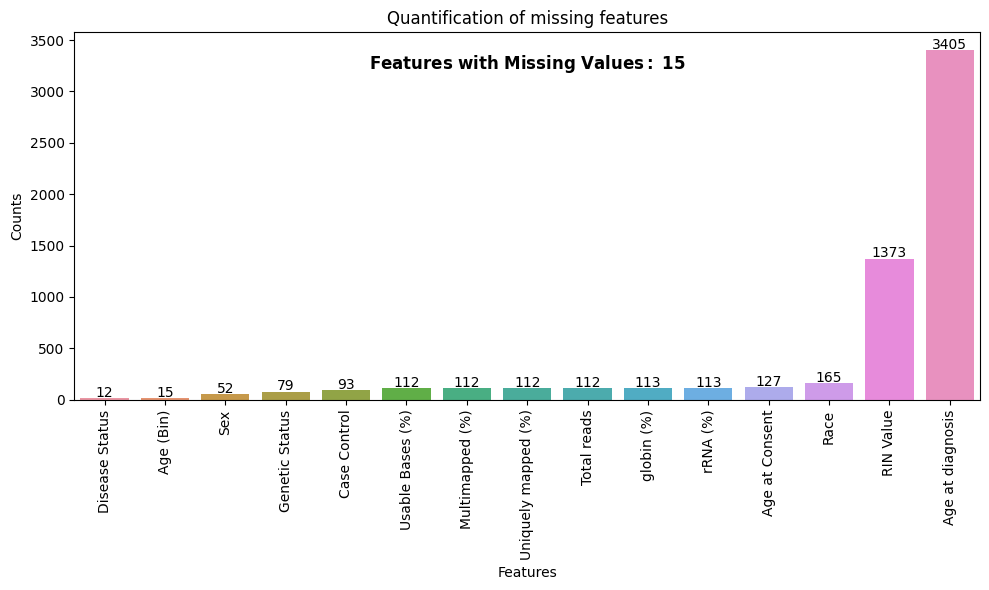

In [5]:
# Calculate the number of missing values for each column
missing_values = RNAseq_md_filt.isnull().sum()

# Filter columns with missing values
missing_columns = missing_values[missing_values > 0]

# Sort the columns by the number of missing values
sorted_missing_columns = missing_columns.sort_values()

# Count the number of features containing missing values
num_missing_features = len(sorted_missing_columns.index)  # Total number of features

# Visualization

# Create a bar plot

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sorted_missing_columns.index, y=sorted_missing_columns.values)
plt.title('Quantification of missing features')
plt.xlabel('Features')
plt.ylabel('Counts')
plt.xticks(rotation=90)

# Add the number of missing values on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height() + 50), ha='center', va='center')

# Add a text label for the number of features containing missing values in bold (using LaTeX-style formatting)
plt.text(0.5, 0.9, f'$\\bf{{Features\ with\ Missing\ Values:}}\ {num_missing_features}$', transform=ax.transAxes, fontsize=12, ha='center')

plt.tight_layout()
plt.show()

### 3.1.3 - Imputation of NGS-QC related Features

Within this code block, we embark on the critical task of imputing missing values in features related to Next-Generation Sequencing (NGS) properties. The process unfolds as follows:

Initially, we group the 'RNAseq_md_filt' dataset by the 'QC' column, organizing the data by its quality control characteristics.

Subsequently, we calculate the median values for essential NGS-related features, including 'Multimapped (%)', 'Usable Bases (%)', 'Uniquely mapped (%)', 'Total reads', 'globin (%)', 'rRNA (%)', and 'RIN Value', within each QC group.

These median statistics are stored in a dictionary format to facilitate imputation.

A dedicated imputation function, 'impute_qc_values', is crafted to fill in missing values within each row of the 'RNAseq_md_filt' DataFrame. The function relies on the QC group of the sample to identify the appropriate median values for imputation, ensuring that each feature retains a contextually relevant estimate.

Finally, the imputation function is applied to the entire 'RNAseq_md_filt' DataFrame, yielding the 'RNAseq_md_filt_imputed' dataset. This dataset now boasts enhanced completeness, aligning it with the quality standards necessary for downstream analysis and interpretation of NGS data.

In [6]:
grouped_df = RNAseq_md_filt.groupby('QC')

imputed_df = grouped_df.agg({feature: lambda x: x.median() for feature in RNAseq_md_filt[['Multimapped (%)','Usable Bases (%)','Uniquely mapped (%)',
                        'Total reads','globin (%)','rRNA (%)','RIN Value']].columns})

# Convert the dataframe to a dictionary
median_stats = imputed_df.to_dict(orient='index')

# Function to impute values based on QC
def impute_qc_values(row):
    qc = row['QC']
    if qc in median_stats.keys():
        median_values = median_stats[qc]
        for feature, median_value in median_values.items():
            if pd.isna(row[feature]):
                row[feature] = median_value
    return row

# Apply the imputation function to the RNAseq_md_filt DataFrame
RNAseq_md_filt_imputed = RNAseq_md_filt.apply(impute_qc_values, axis=1)

### 3.1.4 - Imputation of Disease status feature

This code block is dedicated to enhancing the 'Case Control' column within the 'RNAseq_md_filt_imputed' dataset. The objective is to provide a clear classification of each sample as either a 'Case' or 'Control,' aligning it with the study's overarching goals. Here's a succinct explanation of the steps taken:

We define a mapping dictionary, 'mapping_dct,' which associates 'Disease Status' values with corresponding 'Case Control' classifications. This mapping is designed to ensure that 'Case' or 'Control' status is appropriately assigned to each sample based on their disease status.

Subsequently, we use this mapping to fill in missing values within the 'Case Control' column. The values in 'Case Control' are determined based on the 'Disease Status' column, ensuring that each sample is correctly categorized as a 'Case,' 'Control,' or 'Other' as specified by the mapping.

By performing this mapping-based imputation, we refine the dataset to include a well-defined 'Case Control' column, a crucial element for subsequent analytical insights and interpretations within the study.

In [7]:
# Define the mapping of values
mapping_dct = {
    'Idiopathic PD': 'Case',
    'Genetic PD': 'Case',
    'Healthy Control': 'Control',
    'Genetic Unaffected': 'Control',
    'Prodromal': 'Case',
    'SWEDD': 'Other',
    'Other ND': 'Other'
}

# Fill missing values in "Case Control" column based on "Disease Status" using the mapping
RNAseq_md_filt_imputed['Case Control'].fillna(RNAseq_md_filt_imputed['Disease Status'].map(mapping_dct), inplace=True)

### 3.1.5 - Handling remaining missing values

In [8]:
# Calculate the number of missing values for each column
missing_values = RNAseq_md_filt_imputed.isnull().sum()

# Filter columns with missing values
missing_columns = missing_values[missing_values > 0]

# Sort the columns by the number of missing values
sorted_missing_columns = missing_columns.sort_values()
print(sorted_missing_columns)

Disease Status        12
Case Control          12
Age (Bin)             15
Sex                   52
Genetic Status        79
Age at Consent       127
Race                 165
Age at diagnosis    3405
dtype: int64


In the final step of our data preparation process, we take a closer look at any remaining missing values within the 'RNAseq_md_filt_imputed' dataset. Notably, these missing values predominantly pertain to categorical features.

However, we have opted not to continue with imputation for these categorical features. The rationale behind this decision is that the absence of data in these columns genuinely reflects a lack of information rather than data incompleteness. Imputing values in such cases could introduce bias or inaccuracies into our analysis by assigning arbitrary values to represent missing information.

By acknowledging the absence of data in these categorical columns, we maintain the integrity of our dataset and ensure that our analysis and interpretation are grounded in the most accurate and meaningful information available. This approach aligns with best practices for handling missing data, especially in scenarios where imputation may not be appropriate.

## 3.2 - Medication data

### 3.2.1 - Data processing

To begin, we select specific columns of interest from the 'Medication' DataFrame, namely 'PATNO' (patient identifier), 'CMTRT' (treatment), 'WHODRUG' (drug identification), 'CMDOSE' (dose), 'CMDOSU' (dose unit), 'CMDOSFRQ' (dose frequency), 'CMINDC_TEXT' (indication or reason for medication), 'STARTDT' (start date), 'STOPDT' (stop date), and 'ONGOING' (status of medication).

Subsequently, we create a new DataFrame, 'Medication_nn,' containing only the rows with complete information in columns related to dose, dose unit, dose frequency, and medication indication. This filtering ensures that we work with records containing sufficient and relevant medication details.

The resulting 'Medication' DataFrame provides us with a refined and focused dataset, optimized for further exploration and analysis, while excluding less critical medical condition information.

In [9]:
cols = ['PATNO','CMTRT','WHODRUG','CMDOSE','CMDOSU','CMDOSFRQ','CMINDC_TEXT','STARTDT','STOPDT','ONGOING']
Medication = Medication[cols].copy()

Medication_nn = Medication[Medication[['CMDOSE', 'CMDOSU', 'CMDOSFRQ', 'CMINDC_TEXT']].notnull().all(axis=1)].copy()

Medication.head()

,PATNO,CMTRT,WHODRUG,CMDOSE,CMDOSU,CMDOSFRQ,CMINDC_TEXT,STARTDT,STOPDT,ONGOING
0,3000,Lisinopril,NaN,NaN,NaN,NaN,NaN,01/2016,NaN,NaN
1,3000,MELATONIN,MELATONIN,3.0,MG,PRN,INSOMNIA,04/2013,06/2014,0.0
2,3000,PNEUMOVAX,PNEUMOVAX,25.0,MCG,ONCE,AT RISK POPULATION,02/2017,02/2017,0.0
3,3000,LISINOPRIL,LISINOPRIL,20.0,MG,QD,HYPERTENSION,01/2006,06/2020,0.0
4,3000,HYDROCHLOROTHIAZIDE,HYDROCHLOROTHIAZIDE,25.0,MG,QD,HYPERTENSION,01/2006,06/2020,0.0


### 3.2.2 - Topic Classification of Pharmacological Treatments with GPT-4

In this section, we aim to classify pharmacological treatments into two distinct categories based on their therapeutic use and suitability:

**Disease-modifying drug**: These are compounds that have the potential to treat or manage a specific medical condition or disease.
**PD-indicated drug**: These are compounds specifically designed or suitable for the treatment or management of Parkinson's disease (PD).

### 3.2.2.1 Environment Configuration: Importing OPEN-API Keys

Before making any API calls, it's essential to ensure that the necessary authentication keys are available. This block of code achieves this by:

1. Reading the hf.env file, which contains the API key.
2. Setting the key as an environmental variable, which will be used in subsequent API requests.

In [10]:
from dotenv import dotenv_values
import os

secrets = dotenv_values('hf.env') # imports the env file as a dictionary. Env is essentially a YAML file

# We store the keys as an enviromental variable
os.environ['OPENAI_API_KEY'] = secrets['PASS']

#### 3.2.2.2 - Structuring GPT-4 Output using langchain

To ensure that the responses from the GPT-4 model are structured and easy to interpret, we use the Langchain library. This block:

Defines the expected response schema.
Creates a parser that will format the model's output according to the defined schema.

In [11]:
response_schemas = [
ResponseSchema(name="WHODRUG", description=''' 
Name of the drug mentioned in the input
'''),
ResponseSchema(name="Disease-modifying drug", description='''
Predicted topic based on their therapeutic use
'''),
ResponseSchema(name="PD_indicated_drug", description='''
Predicted topic based on their therapeutic suitability against parkinson disease
''')
]
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"WHODRUG": string  //  
Name of the drug mentioned in the input

	"Disease-modifying drug": string  // 
Predicted topic based on their therapeutic use

	"PD_indicated_drug": string  // 
Predicted topic based on their therapeutic suitability against parkinson disease

}
```


#### 3.2.2.3 - Crafting the Prompt for GPT-4

To guide the GPT-4 model in its predictions, we provide it with a detailed prompt. This prompt:

1. Describes the two classification tasks.
2. Defines the criteria for classifying drugs in each category.
3. Provides examples to aid the model's understanding.

In [12]:
system_message = '''
Performs 2 topic prediction tasks:

1 - Disease-modifying drug classification

Classify drugs into one of the following categories:

Disease-modifying agents: Drugs or medications that are prescribed or used to treat, manage, or prevent a disease, disorder, or medical condition. They 
are designed to have a direct effect on the body's physiology or biochemistry and are often used to alleviate symptoms, slow down or halt the progression of a disease, or cure a medical condition.

Examples: Antibiotics, painkillers, antihistamines, antidepressants, chemotherapy drugs, etc.

Non-disease-modifying agents: Substances that are not intended to treat, manage, or prevent a disease, disorder, or medical condition. They may be used for
other purposes such as nutritional support, hydration, or personal care. Non-therapeutic agents may also include substances that are used for recreational or 
social purposes, such as alcohol or nicotine.

Examples: Vitamins, minerals, amino acids, herbal supplements, protein powder, creatine, sports drinks, energy drinks, etc.

2 - Parkinson disease drug classification

Classify drugs into one of the following categories:

- parkinson_drug: If a drug is indicated to treat parkinson disease
- Non-parkinson_drug: If a drug is NOT indicated to treat parkinson disease
'''

human_message = 'Process users data as best as possible.\n{format_instructions}\n{data}'

#### 3.2.2.4 - Making API Calls to GPT-4 and Storing the Results

In this section, we:

1. Define the prompt templates for system and human messages.
2. Initialize the GPT-4 model.
3. Process a list of drug names, classify them using the model, and store the results in a list.
4. Finally, the results are saved to a pickle file for future use.

In [13]:
#system_message_prompt = SystemMessagePromptTemplate.from_template(system_message)
#human_message_prompt = HumanMessagePromptTemplate.from_template(human_message)

#chat = ChatOpenAI(temperature=0,max_tokens = 200,model_name='gpt-4')

#chat_prompt = ChatPromptTemplate(messages=[system_message_prompt, human_message_prompt],
                                 #input_variables=["data"],
                                 #partial_variables={"format_instructions": format_instructions})

In [14]:
#lst_outputs = []
#total_rows = len(different_ids_list)

#with tqdm(total=total_rows, desc="Processing drug names") as pbar:
   #for data in different_ids_list:
        #_input = chat_prompt.format_prompt(data=data)
        #output = chat(_input.to_messages())
        #lst_outputs.append(output)
        # Update the progress bar
        #pbar.update(1)

#with open('my_list_openai26092022.pkl', 'wb') as file:
    #pickle.dump(lst_outputs, file)

with open('my_list_openai26092022.pkl', 'rb') as file:
    lst_outputs = pickle.load(file)

#### 3.2.2.4 - Parsing the GPT-4 Model's Output

The objective in this section is to parse the results obtained from the GPT-4 model. For each output:

We attempt to parse the content.
If the parsing fails (e.g., due to an unexpected format or missing fields), we increment a counter to keep track of unparsable studies.

In [15]:
parsed_out_lst = []
not_parsable_studies = 0

for output in lst_outputs:
    try:
        parsed_out_lst.append(output_parser.parse(output.content))
    except:
        not_parsable_studies += 1

print(f"Number of unparsable studies: {not_parsable_studies}")

Number of unparsable studies: 26


#### 3.2.2.5 - Data Transformation and Cleaning

Once the outputs are parsed, we proceed with data transformation:

Convert the drug names to uppercase. This standardizes the drug names, facilitating matching and deduplication.
Remove any duplicate drug entries, keeping only the first occurrence of each drug.

In [16]:
gpt4_parsed_drug_df = pd.DataFrame(parsed_out_lst)

# Convert drug names to uppercase for standardization
gpt4_parsed_drug_df['WHODRUG'] = gpt4_parsed_drug_df['WHODRUG'].str.upper()

# Assuming Medication_nn is a previously defined DataFrame
Medication_nn['WHODRUG'] = Medication_nn['WHODRUG'].str.upper()

# Drop duplicates based on the 'WHODRUG' column
gpt4_parsed_drug_df.drop_duplicates(subset=['WHODRUG'], keep='first', inplace=True)

# 4 - Merging Drug DataFrames based on 'WHODRUG'

This section of the code is dedicated to merging the parsed outputs from GPT-4 (gpt4_parsed_drug_df) with another DataFrame, Medication_nn, based on the WHODRUG column. For each drug in the parsed outputs:

We find its corresponding rows in Medication_nn.
Next, we append additional columns (Disease_modifying_drug and PD_indicated_drug) from the parsed outputs to these rows.
Each enhanced row is stored in a list.
Finally, all the rows are concatenated into a single DataFrame.
python


In [17]:
# Initialize a list to store the enhanced rows from Medication_nn
enhanced_rows = []

for _, row in gpt4_parsed_drug_df.iterrows():

    # Extract the WHODRUG value
    whodrug = row['WHODRUG']
    
    # Extract the relevant rows from Medication_nn
    matching_rows = Medication_nn[Medication_nn['WHODRUG'] == whodrug]
    
    # Append the additional columns
    matching_rows = matching_rows.assign(Disease_modifying_drug=row['Disease-modifying drug'])
    matching_rows = matching_rows.assign(PD_indicated_drug=row['PD_indicated_drug'])

    # Store the enhanced rows for later concatenation
    enhanced_rows.append(matching_rows)

# Concatenate all enhanced rows into a single DataFrame
merged_drug_df = pd.concat(enhanced_rows)

In [18]:
merged_drug_df

,PATNO,CMTRT,WHODRUG,CMDOSE,CMDOSU,CMDOSFRQ,CMINDC_TEXT,STARTDT,STOPDT,ONGOING,Disease_modifying_drug,PD_indicated_drug
1,3000,MELATONIN,MELATONIN,3.00,MG,PRN,INSOMNIA,04/2013,06/2014,0.0,Non-disease-modifying agents,Non-parkinson_drug
196,3008,MELATONIN,MELATONIN,3.00,MG,QD,INSOMNIA,08/2014,06/2020,0.0,Non-disease-modifying agents,Non-parkinson_drug
392,3020,MELATONIN,MELATONIN,300.00,MG,QD,SLEEPING AID,01/2016,06/2020,0.0,Non-disease-modifying agents,Non-parkinson_drug
622,3052,MELATONIN,MELATONIN,5.00,MG,QD,SLEEP,02/2019,06/2020,0.0,Non-disease-modifying agents,Non-parkinson_drug
774,3057,MELATONIN,MELATONIN,1.00,TAB,PRN,TROUBLE SLEEPING,04/2012,09/2012,0.0,Non-disease-modifying agents,Non-parkinson_drug
...,...,...,...,...,...,...,...,...,...,...,...,...
10192,3835,PROPIVERIN HCL,PROPIVERIN HCL STADA,30.00,MG,QD,URINARY INCONTINENCE,07/2017,01/2020,0.0,Disease-modifying agents,Non-parkinson_drug
13150,14281,RESTORE,RESTORE,1.00,TSP,TID,PROPHYLAXIS,04/2017,02/2018,0.0,Non-disease-modifying agents,Non-parkinson_drug
19825,56169,RESTORE,RESTORE,2.50,ML,QD,HEALTH PROPHYLAXIS,01/2018,01/2019,0.0,Non-disease-modifying agents,Non-parkinson_drug
18507,53677,SYNTHYROID,SYNTHYROID,75.00,MG,QD,HYPERTHYOIDISM,01/1996,06/2020,0.0,Disease-modifying agents,Non-parkinson_drug


# 5 - Patient-Centric Aggregation and Organization of Medication Data

## 5.1  - Aggregating Drug Data by Patient

The primary goal of this section is to aggregate and summarize the drug data at a patient level. We accomplish this by:

1. Grouping the data by patient number (PATNO).
2. Counting the total number of drugs for each patient.
3. Calculating the number of drugs that fall into specific categories (Disease_modifying_drug and PD_indicated_drug).

In [19]:
# Group and aggregate the drug data by patient
drug_summary_df = merged_drug_df.groupby('PATNO').agg({
    'WHODRUG': 'size',
    'Disease_modifying_drug': lambda x: sum(x == 'Non-disease-modifying agents'),
    'PD_indicated_drug': lambda x: sum(x == 'parkinson_drug')
})

drug_summary_df['Non_disease_modifying_drug'] = drug_summary_df['WHODRUG'] - drug_summary_df['Disease_modifying_drug']

## 5.2 - Constructing a Patient Medication Dictionary

To better manage and access the medication data of each patient, we:

1. Create a dictionary (patient_dict).
2. For each patient, store a sub-dictionary with details of their medications.

In [21]:
patient_dict = {}

for patno, group in merged_drug_df.groupby('PATNO'):
    patient_dict[patno] = {
        'CMTRT': list(group['CMTRT']),
        'WHODRUG': list(group['WHODRUG']),
        'CMDOSE': list(group['CMDOSE']),
        'CMDOSU': list(group['CMDOSU']),
        'CMDOSFRQ': list(group['CMDOSFRQ']),
        'CMINDC_TEXT': list(group['CMINDC_TEXT']),
        'STARTDT': list(group['STARTDT']),
        'STOPDT': list(group['STOPDT']),
        'ONGOING': list(group['ONGOING'])
    }

## 5.3 - Associating Medication Properties to Drug Summary Data

Now that we have the summarized drug data and the patient medication dictionary:

1. We add a new column, Medication_properties, to the summary DataFrame.
2. This column will store medication details for each patient.
3. We then populate this column using the patient_dict.

In [22]:
# Add a placeholder column for medication properties
drug_summary_df['Medication_properties'] = None

# apply a function to each row in df_pivoted and return the corresponding medication properties
def get_medication_properties(row):
    medname = row.name
    if medname in patient_dict:
        return patient_dict[medname]
    else:
        return None

# Populate the medication properties column using the patient dictionary
drug_summary_df['Medication_properties'] = drug_summary_df.apply(get_medication_properties, axis=1)

# Resetting the index for better data organization
drug_summary_df = drug_summary_df.reset_index()

# 6 - Feature Engineering: Calculating Medication Durations by Patient and Drug Type

This section focuses on transforming the merged_drug_df to compute new features representing the duration each patient has been under different types of medications, specifically emphasizing disease-modifying drugs and drugs indicated for Parkinson's disease.

## 6.1 - Computing Duration for Disease-Modifying Drugs

Here, we compute the time each patient has been on drugs with disease-modifying properties:

1. Convert date columns to the appropriate datetime format.
2. Group the data by patient and drug type.
3. Impute missing start dates, if any.
4. Calculate the medication duration and store relevant information.

In [24]:
merged_drug_df['STARTDT'] = pd.to_datetime(merged_drug_df['STARTDT'])
merged_drug_df['STOPDT'] = pd.to_datetime(merged_drug_df['STOPDT'])

disease_modifying_durations = []

for patno, group in merged_drug_df.groupby(['PATNO', 'Disease_modifying_drug']):
    patient_medication_duration = {}
    if group['STARTDT'].isnull().values.any():
        group['STARTDT'] = group['STARTDT'].fillna(group['STARTDT'].mean())
    group['medication_time'] = (group['STOPDT'] - group['STARTDT']).dt.total_seconds() / 86400
    
    patient_medication_duration['patient'] = patno[0]
    patient_medication_duration['Disease_modifying_group'] = patno[1]
    patient_medication_duration['medication_time'] = group['medication_time'].median()
    
    disease_modifying_durations.append(patient_medication_duration)

disease_modifying_duration_df = pd.DataFrame(disease_modifying_durations)
disease_modifying_duration_df['medication_time'].fillna(0, inplace=True)
disease_modifying_duration_df = disease_modifying_duration_df.pivot_table(index='patient', columns='Disease_modifying_group', values='medication_time')

/var/folders/7b/stv1v9_d4nvg0_31qmdnnlsr0000gn/T/ipykernel_87513/3059727018.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_drug_df['STARTDT'] = pd.to_datetime(merged_drug_df['STARTDT'])
/var/folders/7b/stv1v9_d4nvg0_31qmdnnlsr0000gn/T/ipykernel_87513/3059727018.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_drug_df['STOPDT'] = pd.to_datetime(merged_drug_df['STOPDT'])
/Users/felipe/miniconda3/envs/google_batch/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felipe/miniconda3/envs/google_batch/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of e

## 6.2 - Computing Duration for Parkinson's Disease Drugs

This segment focuses on the duration patients have been on drugs specifically indicated for Parkinson's disease:

1. Group data by patient and Parkinson's disease indication.
2. Handle missing start dates.
3. Compute the medication duration and organize the information.

In [25]:
parkinson_drug_durations = []

for patno, group in merged_drug_df.groupby(['PATNO', 'PD_indicated_drug']):
    patient_medication_duration = {}
    if group['STARTDT'].isnull().values.any():
        group['STARTDT'] = group['STARTDT'].fillna(group['STARTDT'].mean())
    group['parkinson_medication_time'] = (group['STOPDT'] - group['STARTDT']).dt.total_seconds() / 86400
    
    patient_medication_duration['patient'] = patno[0]
    patient_medication_duration['Disease_modifying_group'] = patno[1]
    patient_medication_duration['parkinson_medication_time'] = group['parkinson_medication_time'].median()
    
    parkinson_drug_durations.append(patient_medication_duration)

parkinson_drug_duration_df = pd.DataFrame(parkinson_drug_durations)

/Users/felipe/miniconda3/envs/google_batch/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felipe/miniconda3/envs/google_batch/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felipe/miniconda3/envs/google_batch/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felipe/miniconda3/envs/google_batch/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felipe/miniconda3/envs/google_batch/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/felipe/m

## 6.3 - Finalizing Medication Duration Data

With the medication times computed for both categories, we:

1. Merge the two sets of data.
2. Clean and rename columns for clarity.

In [27]:
# Filtering the DataFrame for only records where 'Disease_modifying_group' is 'parkinson_drug'
filtered_parkinson_drug_df = parkinson_drug_duration_df[parkinson_drug_duration_df['Disease_modifying_group'] == 'parkinson_drug']

# Creating a set of unique patients who are taking 'parkinson_drug'
unique_patients_taking_drug = set(filtered_parkinson_drug_df['patient'])

# Creating a new DataFrame containing all unique patients
all_patients_PD_med_time = pd.DataFrame(parkinson_drug_duration_df['patient'].unique(), columns=['patient'])

# Adding a new column 'parkinson_medication_time'
all_patients_PD_med_time['parkinson_medication_time'] = all_patients_PD_med_time['patient'].map(lambda x: filtered_parkinson_drug_df[filtered_parkinson_drug_df['patient']==x]['parkinson_medication_time'].values[0] if x in unique_patients_taking_drug else 0)

# 3 - Merging medication times

final_medication_durations_df = pd.merge(disease_modifying_duration_df, all_patients_PD_med_time, on = 'patient')
final_medication_durations_df.drop(columns='Unknown',inplace = True)

final_medication_durations_df.rename({'patient':'PATNO','Disease-modifying agents':
                                      'Disease-modifying-drugs_time(Median)',
                                      'Non-disease-modifying agents' : 'Non-disease-modifying-drugs_time(Median)'},
                                       axis = 1, inplace = True)

# 7 - Merge tables into a single data frame

We will merge the 3 tables using the column PATNO.

**final_medication_durations_df**,

**RNAseq_md_filt_imputed**,

**drug_summary_df**

In [31]:
centralized_df = pd.merge(drug_summary_df, final_medication_durations_df, on='PATNO')
centralized_df = pd.merge(centralized_df, RNAseq_md_filt_imputed, on='PATNO', how = 'right')

# 8 - Categorizing each patient based on their drug prescription details

In [59]:
# Categorizing each patient based on their drug prescription details
def categorize_patient(row):
    if row['Disease_modifying_drug'] > 0 and row['Non_disease_modifying_drug'] > 0:
        return 'Both'
    elif row['Disease_modifying_drug'] > 0:
        return 'Disease-modifying only'
    elif row['Non_disease_modifying_drug'] > 0:
        return 'Non-disease-modifying only'
    else:
        return 'No treatments'

# Applying the categorization function
centralized_df['Drug_Category'] = centralized_df.apply(categorize_patient, axis=1)

In [39]:
# Calculate combined total number of drugs and combined median time for all drugs

centralized_df['Total_Drugs'] = centralized_df['Disease_modifying_drug'] + centralized_df['Non_disease_modifying_drug']
centralized_df['Total_Drugs_Time(Median)'] = centralized_df['Disease-modifying-drugs_time(Median)'] + centralized_df['Non-disease-modifying-drugs_time(Median)']

In [61]:
centralized_df.to_csv('DF_03102023_v2.csv')